# FRET Burst Variance Analysis

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from typing import Dict, Any, Union, List, Tuple

import numpy as np
import pandas as pd
import pylab as plt

import tqdm
import pathlib
import tttrlib

In [2]:
def write_bv4_analysis(df: pd.DataFrame, analysis_folder: str = "analysis"):
    """
    Writes Burst Variance Analysis (BVA) results to .bv4 files in a 'bv4' subfolder inside the
    specified analysis folder. Each TTTR file will have a corresponding .bv4 file containing
    the mean and standard deviation of the proximity ratio for each burst.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing burst data with columns 'First File', 'Proximity Ratio Mean',
        and 'Proximity Ratio Std'.
    analysis_folder : str, optional
        The path to the folder where the 'bv4' subfolder will be created. Default is 'analysis'.
    """

    # Use pathlib to create the analysis/bv4 folder if it doesn't exist
    bv4_folder = pathlib.Path(analysis_folder) / "bv4"
    bv4_folder.mkdir(parents=True, exist_ok=True)

    bv4_all = list()
    # Iterate through the DataFrame and write results to individual .bv4 files
    for _, row in df.iterrows():
        # Create the corresponding .bv4 file name based on the 'First File' column
        tttr_stem = pathlib.Path(row['First File']).stem
        bv4_filename = bv4_folder / f"{tttr_stem}.bv4"

        # Prepare a mini DataFrame with the required columns for the .bv4 file
        data = {
            'Mean Proximity Ratio': [row['Proximity Ratio Mean']],
            'Standard Deviation': [row['Proximity Ratio Std']]  # Standard deviation
        }
        bv4_df = pd.DataFrame(data)
        bv4_all.append(bv4_df)

        # Write the mini DataFrame to a .bv4 file using tab as the separator
    df_bv4_all = pd.concat(bv4_all)
    df_bv4_all.to_csv(bv4_filename, sep='\t', index=False, mode='a')

    print(f"BVA results have been written to .bv4 files in the '{bv4_folder}' directory.")


In [3]:
def read_burst_analysis(
        paris_path: pathlib.Path,
        tttr_file_type: str,
        pattern: str = 'b*4*',
        row_stride: int = 1
) -> (pd.DataFrame, Dict[str, tttrlib.TTTR]):
    """
    Reads and processes burst analysis data files from a specified directory,
    constructs a pandas DataFrame with the concatenated data, and populates a
    dictionary containing TTTR (Time Tagging and Time Resolved) data.

    This function supports TTTR file types as defined by the tttrlib library and
    allows for flexible reading of files based on a specified glob pattern. It
    handles data from multiple files and can accommodate files generated by
    Seidel software, which may require skipping additional rows.

    Parameters:
    ----------
    paris_path : pathlib.Path
        The path to the directory containing the burst analysis data files.
    tttr_file_type : str
        The file type for TTTR processing (e.g., 'PTU', 'HDF5', etc.), as supported by tttrlib.
    pattern : str, optional
        A glob pattern to match files in the directory. The default is 'b*4*',
        which will match files that start with 'b', contain '4', and have any extension.
    row_stride : int, optional
        The number of rows to skip between reads. The default is 1.
        If the data files are created by Seidel software (e.g., PARIS software),
        set `row_stride` to 2 to account for additional header rows that need to be skipped.

    Returns:
    -------
    Tuple[pd.DataFrame, Dict[str, tttrlib.TTTR]]
        A tuple containing:
        - A pandas DataFrame with the concatenated data from all matched files.
        - A dictionary with keys as filenames (from the 'First File' column) and values
          as TTTR data objects corresponding to those files.

    Raises:
    ------
    FileNotFoundError
        If the specified `paris_path` does not exist or is not a directory.
    ValueError
        If any conversion to numeric fails for columns after the first file is processed.

    Examples:
    --------
    >>> df, tttrs = read_burst_analysis(pathlib.Path('/path/to/data'), 'PTU', pattern='data*')
    >>> print(df.head())
    >>> print(tttrs.keys())
    """

    def update_tttr_dict(data_path, tttrs: Dict[str, tttrlib.TTTR] = dict()):
        for ff, fl in zip(df['First File'], df['Last File']):
            try:
                tttr = tttrs[ff]
            except KeyError:
                fn = str(data_path / ff)
                tttr = tttrlib.TTTR(fn, tttr_file_type)
                tttrs[ff] = tttr
        return tttrs

    info_path = paris_path / 'Info'
    data_path = paris_path.parent

    dfs = list()
    is_first_file = True  # Flag to track the first file
    for path in paris_path.glob(pattern):
        frames = list()
        for fn in sorted(path.glob('*')):
            with open(fn) as f:
                t = f.readlines()
                t = [line.rstrip('\n') for line in t]  # Remove trailing newlines
                h = t[0].split('\t')
                d = [[x for x in l.split('\t')] for l in t[2::row_stride]]
                frames.append(pd.DataFrame(d, columns=h))
        dfs.append(pd.concat(frames))
    df = pd.concat(dfs, axis=1)

    # Loop through each column and attempt to convert to numeric
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            if not is_first_file:  # Ignore conversion errors only for the first file
                print(f"read_burst_analysis: Could not convert {column} to numeric")
        is_first_file = False  # After processing the first file, set flag to False

    tttrs = dict()
    update_tttr_dict(data_path, tttrs)
    return df, tttrs


In [4]:
def compute_static_bva_line(
        prox_mean_bins: np.ndarray,  # Proximity ratio bins
        number_of_photons_per_slice: int = 4,
        n_samples: int = 10_000
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulates fluorescence burst variance analysis (BVA) by calculating the mean
    and standard deviation of proximity ratios for a static species based on the
    assumption of binomial photon emission distribution.

    In BVA, the proximity ratio between two fluorescent species (e.g., acceptor and donor)
    is calculated using the number of photons emitted in specific time slices. This function
    simulates photon counts using a binomial distribution, where photons are randomly
    assigned to each species based on the provided proximity ratios.

    Parameters:
    ----------
    prox_mean_bins : np.ndarray
        An array of proximity ratio bins, representing the expected ratio of emitted
        photons from the donor and acceptor species.

    number_of_photons_per_slice : int, optional
        The total number of photons emitted per time slice. Default is 4.

    n_samples : int, optional
        The number of samples to simulate for each proximity ratio bin. Default is 10,000.

    Returns:
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing two arrays:
        - prox_mean: An array of mean proximity ratios for each bin.
        - prox_sd: An array of standard deviations of proximity ratios for each bin.
    """
    prox_mean = np.zeros(len(prox_mean_bins))  # Preallocate for mean proximity ratios
    prox_sd = np.zeros(len(prox_mean_bins))  # Preallocate for standard deviations

    for i, prox in enumerate(prox_mean_bins):
        # Simulate red photons based on the proximity ratio
        prox_sim_red = np.random.binomial(number_of_photons_per_slice, prox, n_samples)
        prox_sim_green = number_of_photons_per_slice - prox_sim_red

        # Calculate proximity ratio for the simulated counts
        # Using np.where to avoid division by zero and improve performance
        total_photons = prox_sim_red + prox_sim_green
        prox_ratios = np.where(total_photons > 0, prox_sim_red / total_photons, 0)

        # Store the mean and standard deviation of proximity ratios
        prox_mean[i] = prox_ratios.mean()
        prox_sd[i] = prox_ratios.std()

    return prox_mean, prox_sd

In [5]:
def run_bva(
    paris_path,
    file_type,
    bva_settings,
):
    df, tttrs = read_burst_analysis(paris_path, file_type)
    
    plt.title('Bust duration')
    counts, bins, patches =  plt.hist(df['Duration (ms)'], bins=np.linspace(0, 60, 31), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
    plt.xlabel('Duration (ms)')
    plt.ylabel('Counts')
    
    df = chisurf.fluorescence.burst.compute_bva(df, tttrs, **bva_settings)
    # Make plot
    plt.title('Burst variance analysis')
    plt.xlabel('Mean proximity ratio, M(PR)')
    plt.ylabel('PR standard deviation, SD(PR)')
    [xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.5)
    bins = 31, 31
    vmin, vmax = 0.5, 100
    df_selected = df[df['Proximity Ratio Std'] > 0.0]
    counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(
        df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], 
        range=[[xmin, xmax], [ymin, ymax]], 
        bins=bins, vmin=vmin, vmax=vmax,
        cmap='magma'
    )
    
    prox_mean_sim, prox_sd_sim = compute_static_bva_line(prox_mean_bins, bva_settings['number_of_photons_per_slice'])
    mean, sd = average_histogram(counts, prox_mean_bins, prox_sd_bins)
    plt.plot(prox_mean_sim, prox_sd_sim, 'w')
    _ = plt.errorbar(prox_mean_bins[1:], mean, yerr=sd, fmt='ob', alpha=0.3)
    write_bv4_analysis(df, paris_path)

In [6]:
def compute_bva(
        df: pd.DataFrame,  # Target data frame
        tttrs: Dict[str, 'tttrlib.TTTR'],  # Dictionary of TTTR data indexed by 'First File'
        donor_channels: List[int] = [0, 8],  # Channels for donor fluorescence detection
        donor_micro_time_ranges: List[Tuple[int, int]] = [(0, 4096)],  # Microtime ranges for donor photons
        acceptor_channels: List[int] = [1, 9],  # Channels for acceptor fluorescence detection
        acceptor_micro_time_ranges: List[Tuple[int, int]] = [(0, 4096)],  # Microtime ranges for acceptor photons
        minimum_window_length: float = 0.01,  # Minimum time window length within burst
        number_of_photons_per_slice: int = -1  # Number of photons per time slice (-1 to use time windows)
) -> pd.DataFrame:
    """
    Computes proximity ratio statistics (mean and standard deviation) for fluorescence bursts using
    Burst Variance Analysis (BVA). The proximity ratio compares the number of photons detected from
    donor and acceptor species within a burst, helping to analyze dynamic changes in Förster resonance
    energy transfer (FRET) or other fluorescence events.

    Burst Variance Analysis (BVA) involves breaking down fluorescence bursts into time windows or slices,
    calculating the ratio of photons detected from two fluorophores (donor and acceptor) in each time window.
    The proximity ratio is used to examine fluctuations within bursts, providing insight into the dynamic
    behavior of molecular interactions.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing burst data with columns 'First File', 'Last File', 'First Photon', and 'Last Photon'.
    tttrs : Dict[str, 'tttrlib.TTTR']
        Dictionary containing TTTR (Time Tagging and Time Resolved) data for each burst indexed by 'First File'.
    donor_channels : List[int], optional
        List of routing channels for donor photon detection. Default is [0, 8].
    donor_micro_time_ranges : List[Tuple[int, int]], optional
        Microtime ranges for donor photons. Default is [(0, 4096)].
    acceptor_channels : List[int], optional
        List of routing channels for acceptor photon detection. Default is [1, 9].
    acceptor_micro_time_ranges : List[Tuple[int, int]], optional
        Microtime ranges for acceptor photons. Default is [(0, 4096)].
    minimum_window_length : float, optional
        Minimum time window length within a burst for dividing photon events into slices. Default is 0.01.
    number_of_photons_per_slice : int, optional
        If set to a positive value, divides bursts into slices containing a fixed number of photons.
        If set to -1, divides bursts based on time windows of `minimum_window_length`. Default is -1.

    Returns:
    -------
    pd.DataFrame
        Updated DataFrame with added columns for proximity ratio mean ('Proximity Ratio Mean') and
        standard deviation ('Proximity Ratio Std') for each burst.
    """


    # Initialize lists to store the proximity ratio statistics
    proximity_ratios_mean, proximity_ratios_sd = list(), list()

    # Iterate through rows using iterrows()
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
        # Select tttr data of burst out of dictionary
        ff, fl = row['First File'], row['Last File']
        tttr = tttrs[ff]
        time_calibration = tttr.header.tag('MeasDesc_GlobalResolution')['value']

        # Select events within burst
        burst_start, burst_stop = int(row['First Photon']), int(row['Last Photon'])
        burst_tttr = tttr[burst_start:burst_stop]

        # Split bursts into time windows or photon slices
        if number_of_photons_per_slice < 0:
            # Use time windows to split the burst
            burst_tws = burst_tttr.get_ranges_by_time_window(minimum_window_length,
                                                             macro_time_calibration=time_calibration)
            burst_tws = burst_tws.reshape((len(burst_tws) // 2, 2))
            burst_tws_tttr = [burst_tttr[start:stop] for start, stop in burst_tws]
        else:
            # Split bursts into chunks with a fixed number of photons
            chunk_size = number_of_photons_per_slice
            burst_tws_tttr = [burst_tttr[i:i + chunk_size] for i in range(0, len(burst_tttr), chunk_size)]

        # Compute proximity ratios for each time window in the burst
        n_acceptor, n_donor = list(), list()
        for tw_tttr in burst_tws_tttr:
            mt = tw_tttr.micro_times
            ch = tw_tttr.routing_channels

            # Donor photons
            donor_time_mask = np.zeros_like(mt, dtype=bool)
            for start, stop in donor_micro_time_ranges:
                donor_time_mask |= (mt >= start) & (mt <= stop)
            donor_channel_mask = np.isin(ch, donor_channels)
            combined_donor_mask = donor_time_mask & donor_channel_mask

            # Acceptor photons
            acceptor_time_mask = np.zeros_like(mt, dtype=bool)
            for start, stop in acceptor_micro_time_ranges:
                acceptor_time_mask |= (mt >= start) & (mt <= stop)
            acceptor_channel_mask = np.isin(ch, acceptor_channels)
            combined_acceptor_mask = acceptor_time_mask & acceptor_channel_mask

            # Count donor and acceptor photons
            n_donor.append(np.sum(combined_donor_mask))
            n_acceptor.append(np.sum(combined_acceptor_mask))

        # Calculate proximity ratios
        tw_n_acceptor = np.array(n_acceptor)
        tw_n_donor = np.array(n_donor)
        tw_total = tw_n_acceptor + tw_n_donor
        tw_proximity_ratios = tw_n_acceptor / tw_total
        proximity_ratio_mean, proximity_ratio_sd = np.nanmean(tw_proximity_ratios), np.nanstd(tw_proximity_ratios)

        # Store results
        proximity_ratios_mean.append(proximity_ratio_mean)
        proximity_ratios_sd.append(proximity_ratio_sd)

    # Update DataFrame with computed proximity ratio statistics
    df['Proximity Ratio Mean'] = np.array(proximity_ratios_mean)
    df['Proximity Ratio Std'] = np.array(proximity_ratios_sd)

    return df

In [7]:
def make_2d_plot(
    x, y, 
    range_x,
    range_y,
    analysis_folder: pathlib.Path,
    xlabel: str = "x", 
    ylabel: str = "y",
    bins_x: int = 100,
    bins_y: int = 100,
    log_x: bool = False,
    log_y: bool = False,
    vmin: float = None,
    vmax: float = None,
    cmap: str = 'Greys',
    overlays: List = None
): 
    # Define logarithmic bins if required
    if log_x:
        bins_x = np.logspace(np.log10(range_x[0]), np.log10(range_x[1]), bins_x)
    else:
        bins_x = np.linspace(range_x[0], range_x[1], bins_x)
        
    if log_y:
        bins_y = np.logspace(np.log10(range_y[0]), np.log10(range_y[1]), bins_y)
    else:
        bins_y = np.linspace(range_y[0], range_y[1], bins_y)
    
    # 1. Define function for 2D histogram (e.g., for SPIE vs EFRET)
    def scatter_hist(x, y, ax, ax_histx, ax_histy):
        # Labels of the marginal distribution
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        
        # 2D histogram with optional log scaling
        hist2D = ax.hist2d(x, y, bins=[bins_x, bins_y], cmap=cmap, density=False, vmin=vmin, vmax=vmax)
        
        # Marginal distributions
        xhist = ax_histx.hist(x, bins=bins_x, color="dimgrey")
        yhist = ax_histy.hist(y, bins=bins_y, color="darkorange", orientation='horizontal')
    
        return hist2D, xhist, yhist
    
    # 2. Define a grid
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    
    # 3. Plot the results
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)
    ax.set_xlabel(xlabel, fontsize=16,  fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16,  fontweight='bold')
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # Apply log scaling to the axes if required
    if log_x:
        ax.set_xscale("log")
        ax_histx.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
        ax_histy.set_yscale("log")

    # Set font sizes for tick labels
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax_histx.get_yticklabels() + ax_histy.get_xticklabels()):
        label.set_fontsize(14)

    # 4. Plot and save plot
    filename = analysis_folder.as_posix() + "/"
    xy2D, x_1D, y_1D = scatter_hist(x, y, ax, ax_histx, ax_histy)

    # Plot overlays
    for overlay in overlays:
        ax.plot(*overlay)
    
    plt.savefig(filename + '2D_' + xlabel + '-' + ylabel + '.png')
    plt.show()
    plt.close()

## Select analysis folder
First, select the file type and the burst analysis folder (typically named "burstwise_All 0.1500#60," where 0.1500 and 60 represent selection thresholds). This folder should contain a set of burst files located in the 'bi4_bur' subfolder, which hold the indices of the selected bursts.

Second, define the micro time ranges for the donor and acceptor windows. This step is particularly important for pulsed interleaved excitation (PIE) experiments.

Third, specify the minimum size of the time slice or window within each burst. If number_of_photons_per_slice is set to -1, the burst will be divided into equal time intervals of length minimum_window_length.

Finally, execute the cell below the input widgets. Execution of the cell will create a BVA histogram as a preview and writes the BVA analysis into the 'bv4' subfolder of the burst analysis folder.

In [8]:
file_type = 'SPC-130'           # Type of Time-Tagged Time-Resolved (TTTR) file, specifying the instrument format (e.g., PTU, SPC-130)

# Path to the analysis folder where burst selection data is stored. 
# This folder contains data for burst-wise analysis, including parameters for the dataset "burstwise_All 0.2000#60".
analysis_folder = '/Users/tpeulen/scp132/10-02-01/LP-344-525+7.5uM-UP-344-525_2/burstwise_All 0.2000#60'

# Burst Variance Analysis (BVA) settings for time-resolved fluorescence data.
# This dictionary contains settings to select photon channels and microtime ranges, 
# as well as parameters for photon slicing within each burst.
bva_settings: Dict[str, Union[List[int], List[Tuple[int, int]], float, int]] = {
    "donor_channels": [0, 8],                   # Channels assigned to the donor molecule, typically represented by specific integer IDs.
    "donor_micro_time_ranges": [(0, 32768)],    # Microtime ranges (in integer units) for the donor molecule's photon detections.
    "acceptor_channels": [1, 9],                # Channels assigned to the acceptor molecule, also represented by specific integer IDs.
    "acceptor_micro_time_ranges": [(0, 32768)], # Microtime ranges for the acceptor molecule's photon detections.
    "minimum_window_length": 0.01,              # Minimum window length (in seconds) for time-binned photon analysis within bursts.
    "number_of_photons_per_slice": 10           # Number of photons required per slice, used to subdivide bursts for analysis.
}

In [13]:
analysis_folder = pathlib.Path(analysis_folder)
df, tttrs = read_burst_analysis(analysis_folder, file_type, pattern='bur')
df_v = compute_bva(df, tttrs, **bva_settings)

result = pd.concat([df_v, df], axis=1, join="inner")
result.to_csv(analysis_folder / 'int_tau_bva.csv', sep='\t')

#write_bv4_analysis(df, analysis_folder)

read_burst_analysis: Could not convert First File to numeric
read_burst_analysis: Could not convert Last File to numeric


100%|██████████| 5304/5304 [00:10<00:00, 494.73it/s]


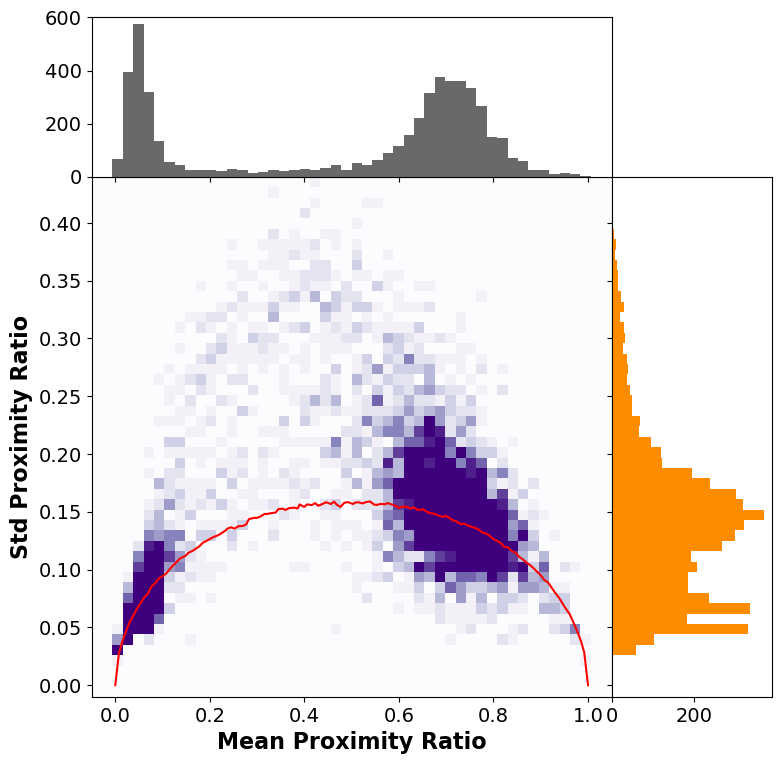

In [10]:
df_selected = df[df['Proximity Ratio Std'] > 0.0]

x = df_selected['Proximity Ratio Mean']
y = df_selected['Proximity Ratio Std']

x_axis = np.linspace(0, 1, 131)
overlays = [
    (*compute_static_bva_line(x_axis, number_of_photons_per_slice=bva_settings['number_of_photons_per_slice']), 'r')
]
make_2d_plot(
    x, y, 
    xlabel = 'Mean Proximity Ratio',
    ylabel = 'Std Proximity Ratio',
    range_x=(-0.05, 1.05), 
    range_y=(-0.01, 0.44), 
    analysis_folder=analysis_folder, 
    vmin=0.1, 
    vmax=10, 
    bins_x = 51,
    bins_y = 51,
    cmap='Purples', 
    overlays=overlays
)